# Task 3

To begin, a file was added to the src folder titled jackson_network.jl. This file contains code relevant for events and states of the system. The first section of this file contains structs for all possible events that could occur in the system. Perhaps it is important to note that the event of a breakdown case was split into two distinct events: BreakdownEvent and RepairEvent. The structs for ExternalArrivalEvent (Line 29) and EndOfServiceAtQueueEvent (Line 34) are given below.

In [ ]:
# External arrival event 
struct ExternalArrivalEvent <: Event 
    next_q::Int # Queue initial job is assigned to 
end
 
# End of service event 
mutable struct EndOfServiceAtQueueEvent <: Event
    q::Int # Queue where service finished
    next_q::Any # Queue where job moves after service. nothing if job leaves system.
end

The next section of the file contains functions associated with the random variables of arrivals, services and breakdowns. Breakdowns were split into a breakdown duration, and repair duration case. Functions for these cases (line 91 and line 99) are given below. 

In [ ]:
"""
A function, acting as a RV, for breakdowns in the system.

Breakdowns occur independently of jobs in the system and independent of servers.
Breakdown are exponentially distributed with rate γ₂, which is given as a parameter
of the network system.
"""
next_breakdown_duration(s::State, q::Int) = rand(Exponential(1/s.params.γ₂))

"""
A function, acting as a RV, for reparis of breakdowns in the system.

Repairs of breakdowns are exponentially distributed with rate γ₁, 
which is given as a parameter of the network system.
"""
next_repair_duration(s::State, q::Int) = rand(Exponential(1/s.params.γ₁))

The next section contains functions for processing events. Along with end of simulation events and log time events, EndOfServiceAtQueueEvent, ExternalArrivalEvent, BreakdownEvent and RepairEvent's all had to be handled. The function for processing an end of service event (Line 173) is given below.

In [ ]:
"""
Process an end of service event.
"""
function process_event(time::Float64, state::State, eos_event::EndOfServiceAtQueueEvent)
    q = eos_event.q # Queue where service has occured
    if breakdown_states[q] == false # Proceed only if server is not broken down
        state.jobs_num[q] -= 1 # Remove this job from the queue 
        @assert state.jobs_num[q] ≥ 0 
        new_timed_events = TimedEvent[] # Record a new timed event 

        # If another job is in queue then start new service 
        if state.jobs_num[q] ≥ 1
            st = next_service_duration(state, q)
            push!(new_timed_events, TimedEvent(EndOfServiceAtQueueEvent(q, nothing), time + st)) 
        end

        # Routing matrix, P, determines where job will go after service
        # Probability of exiting system included and assigned to "L+1'th" node 
        trans_row = push!(state.params.P[q, :], 1 - sum(state.params.P[q, :])) 
        # Sample from above, trans_q denotes queue job moves to (or exits system)
        trans_q = sample(1:(state.params.L)+1, Weights(trans_row)) 
        # If trans_q is in system, proceed by adding job to the queue
        if trans_q < (state.params.L+1)
            state.jobs_num[trans_q] += 1 # Add job to queue
            eos_event.next_q = trans_q # Set field
            # If this job is only job in queue then start new service event
            if state.jobs_num[trans_q] == 1
                # Record this new timed event
                push!(new_timed_events, TimedEvent(EndOfServiceAtQueueEvent(trans_q, nothing), 
                                            time + next_service_duration(state, trans_q))) 
            end
        end
        return new_timed_events
    else #Wait until the queue is repaired
        new_timed_events = TimedEvent[] # Record a new timed event 
        push!(new_timed_events, TimedEvent(EndOfServiceAtQueueEvent(q, nothing), 
                                            time + next_service_duration(state, q)))
        return new_timed_events
    end
end  

As mentioned above, the breakdown case was split into two distinct cases. Processing a breakdown event, and consequently a "repair" event is handled in the following functions (Line 209 & 220).

In [ ]:
"""
Process a breakdown event.
"""
function process_event(time::Float64, state::State, brk_event::BreakdownEvent)
    q = brk_event.q # Queue where breakdown event occurs
    breakdown_states[q] = true # Server becomes broken down
    # Prepare for next repair event
    new_timed_events = TimedEvent[] # Record a new timed event
    push!(new_timed_events, TimedEvent(RepairEvent(q), time + next_breakdown_duration(state, q)))
    return new_timed_events
end

"""
Process a repair event.
"""
function process_event(time::Float64, state::State, rpr_event::RepairEvent)
    q = rpr_event.q # Queue where breakdown event occurs 
    breakdown_states[q] = false # Repair broken down server 
    # Prepare for next breakdown event 
    new_timed_events = TimedEvent[] 
    push!(new_timed_events, TimedEvent(BreakdownEvent(q), time + next_repair_duration(state, q)))
    return new_timed_events
end 

Finally, helper functions were included at the end of this file which were used in some parts of the code above it. A file was then added in the src folder titled simulation_engine.jl. This file contains the code relevant for running the simulation of the Open Generalised Jackson network with Breakdowns. Within main function named sim_net, a function named simulation executed the simulation. Code for this function is available from Line 26. It is important to notice that for this task and specifically the consequent tests, certain data had to be recorded. This data incldued times & queue lenghts when events occur, times where servers were "on" as well as total arrivals to each server in the system. Exerts of code for recording data for this first case  is given below. 

In [ ]:
#LINE 35
# Times & Queues numbers where events occur 
event_change_times = [] 
event_change_queues_num = []

############################################################################################################################

#LINE 82
# Only record data for total mean queue length past warm up time
if timed_event.time > warm_up_time 
    # If event occurs where a queue length is changed then record it
    if timed_event.event isa EndOfServiceAtQueueEvent # Must ensure servers are "on"                                   
        breakdown_states[timed_event.event.q] == false && push!(event_change_times, timed_event.time)
        breakdown_states[timed_event.event.q] == false && push!(event_change_queues_num, sum(state.jobs_num)) 
    else 
        push!(event_change_times, timed_event.time)
        push!(event_change_queues_num, sum(state.jobs_num)) 
    end
end

After the simulation is run, we can then compute an estimate of the total mean queue length. This is done on Line 142, code is given below.

In [ ]:
# COMPUTING ESTIMATED TOTAL MEAN QUEUE LENGTH 
# Change in time between events where queue length is changed
delta_log_times = [0; diff(event_change_times)]
est_total_mean_q_length = (delta_log_times ⋅ event_change_queues_num) / max_time

The simulation function then returns three pieces of information from the simulation: (1) The estimated total mean queue length, (2) service "on" times and (3) total arrivals of jobs to each server. Information for these latter 2 cases is collected and computed similarly to the first case.

In our implementation, at the end of sim_net, we execute the simulation. With given initial conditions (Line 150) the code is executed on Line 156.

In [ ]:
# Execute the simulation 
simulate(QueueNetworkState([0 for i in 1:net.L], net), initial_conditions, max_time = max_time)

Within the test folder, four files were added, test_one.jl, test_two.jl etc. Within each of these files, the code for the required tests was written.

### Test 1

In [1]:
using Pkg
cd("C:\\Users\\samue\\MATH2504\\Project2\\Samuel-Dick__Patrick-Schmidt-2504-2023-PROJECT2")
Pkg.activate(".")
include("GeneralizedUnreliableJacksonSim.jl")
"""
Test function for theoretical vs. simulated mean queue lengths
"""
function test_one(net::NetworkParameters) 
    ρ_grid = 0.1:0.01:0.9
    theoretical_ρ = steady_state_q_lengths(net) #theoretical ρ values
    mean_lengths = [] #total mean queue lengths via simulation 
    for ρ in ρ_grid 
        # Set new scenario based on ρ*
        new_net = set_scenario(net, ρ)
        # Simulate for above and record simulated mean queue length
        push!(mean_lengths, sim_net(new_net, max_time = Float64(10^5), warm_up_time = 10^3)[1])
    end 

    abs_err = [] # Absolute error between theoretical and simulated 
    for i in 1:length(ρ_grid)
        push!(abs_err, abs(theoretical_ρ[i] - mean_lengths[i]))
    end 

    # Plot simulated mean queue length 
    plt1 = plot(ρ_grid, mean_lengths, 
        xlabel = "ρ*", ylabel = "Total steady state mean queue lengths",
        label = "Simulated", lw = 2, c = :black, xlim = (0,1),ylim=(0,20)) 
    # Plot, on same axis, theoretical mean queue length 
    plot!(ρ_grid, theoretical_ρ, 
        xlabel = "ρ*", ylabel = "Total steady state mean queue lengths",
        label = "Theoretical", lw = 2, linecolour = :red, xlim = (0,1),ylim=(0,20)) 

    plt2 = plot(ρ_grid, abs_err, 
        xlabel = "ρ*", ylabel = "Absolute Error",
        label = "Simulated", lw = 2, xlim = (0,1), ylim=(0,2)) 
        
    plot(plt1, plt2)
end 

  Activating project at `C:\Users\samue\MATH2504\Project2\Samuel-Dick__Patrick-Schmidt-2504-2023-PROJECT2`


test_one

Using the given set of scenarios, the output from the test function is given below. We see that the absolute relative error is particularly small (difference between maximum and minimum), and that the simulation graph is very similar to the theoretical graph. It is important to note as well that as max_time increases, the graph becomes less "noisy". In the example below, max_time is set to 10^5 which removes a sufficient amount of "noise", and consequently absolute error decreases as well.

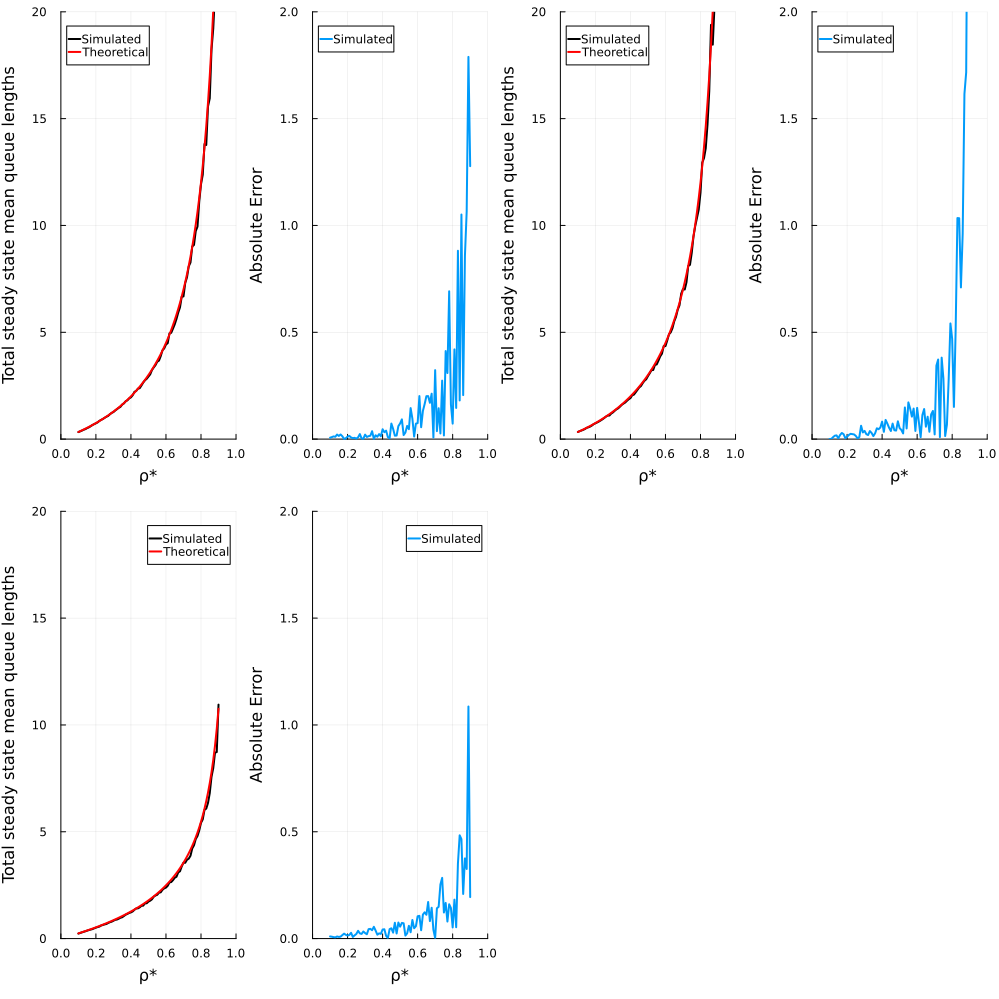

In [9]:
plot(test_one(scenario1), test_one(scenario2), test_one(scenario3), size = (1000,1000))

### Test 2

In [2]:
"""
Test function for the arrival rate of the simulation.
"""
function test_two(net::NetworkParameters)
    ρ = [i*0.2 for i in 1:4] # testing multiple cₛ values 
    cs, R = 0.5, 0.5 # ρ and R values remain constant
    sim_A = [] # simulated Aᵢ(T)/T 
    theoretical_λ = [] # theoretical λᵢs
    for i in ρ
        # Set new scenario based on params 
        new_sim = set_scenario(net, i, cs, R)
        # Simulate the above and push values into sim_A
        push!(sim_A, [j/(10^5) for j in sim_net(new_sim, max_time = Float64(10^5), warm_up_time = 10^3)[3]]) 
        # Compute theoretical value for λ from traffic equations
        λ =  inv((I - new_sim.P')) * new_sim.α_vector 
        push!(theoretical_λ, λ) 
    end 
    df = DataFrame(Simulated  = sim_A, theoretical_λ = theoretical_λ)
    println(df)
    println()

    #Repeat, but now for different cs values to show it remains constant
    cs = [i*0.2 for i in 1:4] # testing multiple cₛ values 
    ρ, R = 0.5, 0.5 # ρ and R values remain constant
    sim_A = [] # simulated Aᵢ(T)/T 
    theoretical_λ = [] # theoretical λᵢs
    for i in cs
        # Set new scenario based on params 
        new_sim = set_scenario(net, ρ, i, R)
        # Simulate the above and push values into sim_A
        push!(sim_A, [j/(10^5) for j in sim_net(new_sim, max_time = Float64(10^5), warm_up_time = 10^3)[3]]) 
    end 
    df1 = DataFrame(cs  = cs, Simulated  = sim_A)
    println(df1)
end 

test_two

Again, using the given set of scenario's, the output from the above test function is given below. The trends follow what was suggested and the values of of $A_i (T)/T$ (labeled "simulated" below) agree with $\lambda_i$ ("theoretical_$\lambda$") and that by changing the value $c_s$, the values are unaffected.

In [3]:
println("SCENARIO 1")
test_two(scenario1)
println("SCENARIO 2")
test_two(scenario2)
println("SCENARIO 3")
test_two(scenario3)

SCENARIO 1
4×2 DataFrame
 Row │ Simulated                    theoretical_λ   
     │ Any                          Any             
─────┼──────────────────────────────────────────────
   1 │ [0.09907, 0.09908, 0.09909]  [0.1, 0.1, 0.1]
   2 │ [0.19928, 0.19929, 0.1993]   [0.2, 0.2, 0.2]
   3 │ [0.29847, 0.29841, 0.29842]  [0.3, 0.3, 0.3]
   4 │ [0.39865, 0.39856, 0.39857]  [0.4, 0.4, 0.4]

4×2 DataFrame
 Row │ cs       Simulated                   
     │ Float64  Any                         
─────┼──────────────────────────────────────
   1 │     0.2  [0.25297, 0.25297, 0.25298]
   2 │     0.4  [0.24865, 0.24864, 0.24864]
   3 │     0.6  [0.24881, 0.24879, 0.24878]
   4 │     0.8  [0.25151, 0.25152, 0.25152]
SCENARIO 2
4×2 DataFrame
 Row │ Simulated                    theoretical_λ   
     │ Any                          Any             
─────┼──────────────────────────────────────────────
   1 │ [0.09889, 0.0989, 0.09891]   [0.1, 0.1, 0.1]
   2 │ [0.20078, 0.20078, 0.20074]  [0.2, 0.2,

### Test 3

In [2]:
using DataFrames 

"""
A test to investigate the long term proportion of time "on" for each server 
with various set values of R.
"""
function test_three(net::NetworkParameters)
    R_vals = [i*0.2 for i in 1:5] # R-values to test
    cs, ρ = 0.5, 0.5 # c_s and ρ values to be constant
    on_prop = [] #Long term proportion of time "on" associated with above
    for r in R_vals
        new_sim = set_scenario(net, ρ, cs, r) # set new senario based on params 
        # Simulate and push rounded long term proportions into on_prop 
        push!(on_prop, [round(x, digits = 3) for x in sim_net(new_sim, max_time = 1000.0, warm_up_time = 10)[2]])
    end
    df = DataFrame(R = R_vals, long_term_proportion_on = on_prop)
    println(df)
end 

test_three

Again, from the given set of scenario's, the output from the above test function is given below. The trend is as expected for each scenario, that as R is increased, the servers are on for a greater amount of time.

In [4]:
println("SCENARIO 1")
test_three(scenario1)
println("SCENARIO 2")
test_three(scenario2)
println("SCENARIO 3")
test_three(scenario3)

SCENARIO 1
5×2 DataFrame
 Row │ R        long_term_proportion_on     
     │ Float64  Any                         
─────┼──────────────────────────────────────
   1 │     0.2  [201.321, 190.338, 198.57]
   2 │     0.4  [385.245, 408.525, 388.994]
   3 │     0.6  [593.73, 616.751, 630.651]
   4 │     0.8  [809.161, 819.757, 784.788]
   5 │     1.0  [1000.0, 1000.0, 1000.0]
SCENARIO 2
5×2 DataFrame
 Row │ R        long_term_proportion_on     
     │ Float64  Any                         
─────┼──────────────────────────────────────
   1 │     0.2  [207.65, 203.039, 198.237]
   2 │     0.4  [407.664, 397.662, 403.938]
   3 │     0.6  [583.407, 582.46, 596.991]
   4 │     0.8  [783.243, 812.132, 772.208]
   5 │     1.0  [1000.0, 1000.0, 1000.0]
SCENARIO 3
5×2 DataFrame
 Row │ R        long_term_proportion_on           
     │ Float64  Any                               
─────┼────────────────────────────────────────────
   1 │     0.2  [203.873, 195.903, 199.573, 206.…
   2 │     0.4  [413.8

### Test 4

In [7]:
"""
Qualitative test for relation between R and mean queue lengths 
"""
function test_four(net::NetworkParameters)
    R = [i*0.025 for i in 1:39] # R-values to test
    cs, ρ = 0.5, 0.5 # cₛ and ρ values to remain constant
    mean_queue_lengths = []  
    for r in R 
        new_net = set_scenario(net, ρ, cs, r)
        push!(mean_queue_lengths, sim_net(new_net, max_time = Float64(10^5), warm_up_time = 10^3)[1])
    end 

    # Plot simulated mean queue lengths on same plot 
    plot(R, mean_queue_lengths, 
        xlabel = "R", ylabel = "Total mean queue lengths",
        label = "Simulated", lw = 2, xlim = (0,1),ylim=(1, 4)) 
end 

test_four

Again, from the given set of scenario's, the output from the above test function is given below. The trend is, as suggested, quadratic. 

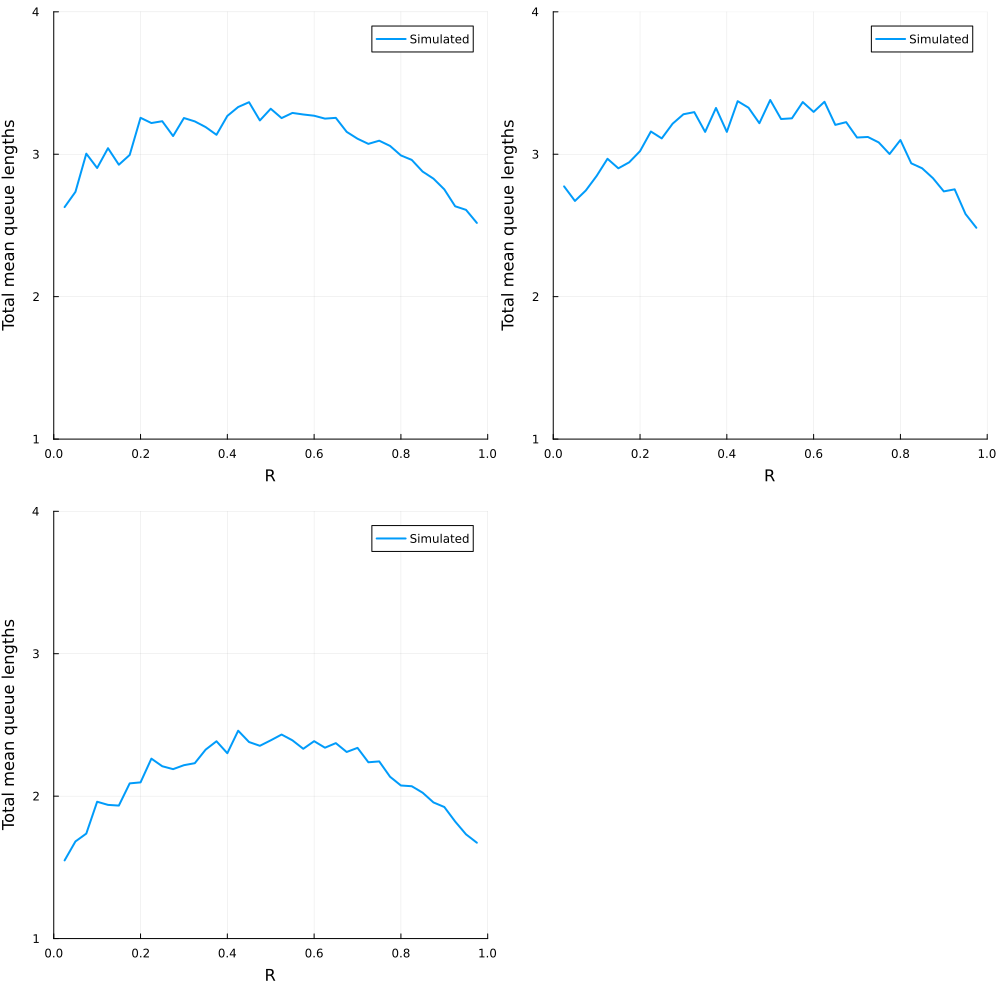

In [8]:
plot(test_four(scenario1), test_four(scenario2), test_four(scenario3), size = (1000,1000))